In [1]:
# Importing the libraries 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense,Dropout, GRU
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD 


In [2]:
#Importing Dataset
df = pd.read_csv("../input/bitcoin-prediction/BTC-USD.csv")
df = df.sort_values('Date').reset_index(drop=True)

In [3]:
#Dataset table visualization 
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


In [4]:
#Dataset rows and cloumn count 
df.shape

(2468, 7)

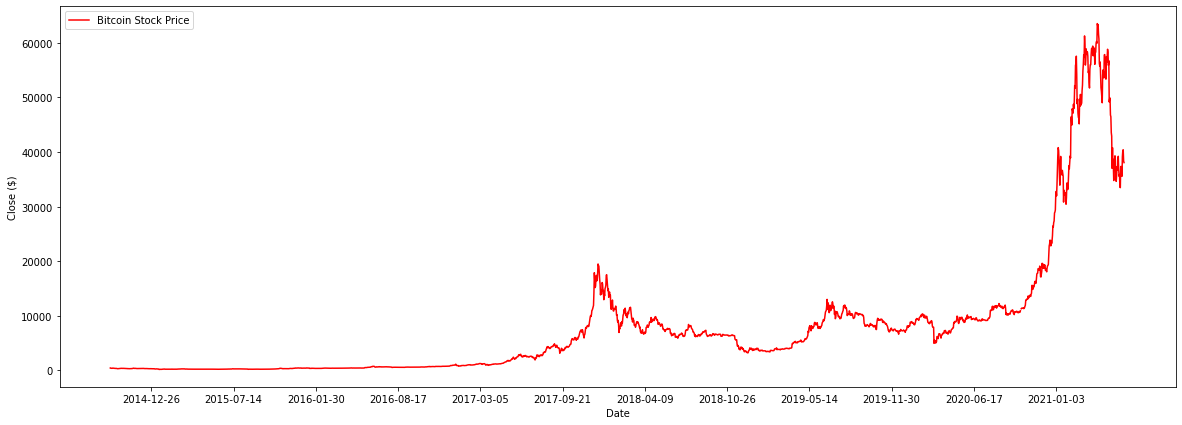

In [5]:
#Ploting Dataset Bitcoin prices  
df['Close'] = df['Close'].astype(float)

plt.figure(figsize=(20,7))
plt.plot(df['Date'].values, df['Close'].values, label = 'Bitcoin Stock Price', color = 'red')
plt.xticks(np.arange(100,df.shape[0],200))
plt.xlabel('Date')
plt.ylabel('Close ($)')
plt.legend()
plt.show()

In [6]:
#Spliting Dataset into Train and Test dataset  
num_shape = 2000
train = df.iloc[:num_shape, 1:2].values
test = df.iloc[num_shape:, 1:2].values

In [7]:
#Featrue Scaling 
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(train)

In [8]:
X_train = []

#Price on next day
y_train = []

window = 60

for i in range(window, num_shape):
    X_train_ = np.reshape(train_scaled[i-window:i, 0], (window, 1))
    X_train.append(X_train_)
    y_train.append(train_scaled[i, 0])
X_train = np.stack(X_train)
y_train = np.stack(y_train)

In [9]:
#Intializing the RNN
modelGRU = Sequential()

#Adding First layer of GRU and some dropout Regulation 
modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

#Adding Second  layer of GRU and some dropout Regulation
modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

#Adding Third layer of GRU and some dropout Regulation
modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

#Adding Fourth  layer of GRU and some dropout Regulation
modelGRU.add(GRU(units=50))
modelGRU.add(Dropout(0.2))

#Adding Output layer 
modelGRU.add(Dense(units=1))
modelGRU.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 60, 50)            7950      
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 60, 50)            15300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 60, 50)            15300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 50)                1

In [ ]:
#Compiling the RNN
modelGRU.compile(optimizer='adam', loss='mean_squared_error')
#Fitting the RNN to the Training set 
modelGRU.fit(X_train, y_train, epochs=100, batch_size=128)

Epoch 1/100
16/16 [==============================] - 16s 374ms/step - loss: 0.0189
Epoch 2/100
16/16 [==============================] - 6s 351ms/step - loss: 0.0039
Epoch 3/100
16/16 [==============================] - 7s 415ms/step - loss: 0.0023
Epoch 4/100
16/16 [==============================] - 6s 372ms/step - loss: 0.0021
Epoch 5/100
16/16 [==============================] - 6s 356ms/step - loss: 0.0020
Epoch 6/100
16/16 [==============================] - 6s 354ms/step - loss: 0.0020
Epoch 7/100
16/16 [==============================] - 6s 360ms/step - loss: 0.0018
Epoch 8/100
16/16 [==============================] - 7s 412ms/step - loss: 0.0017
Epoch 9/100
16/16 [==============================] - 6s 358ms/step - loss: 0.0016
Epoch 10/100
16/16 [==============================] - 6s 366ms/step - loss: 0.0016
Epoch 11/100
16/16 [==============================] - 6s 355ms/step - loss: 0.0018
Epoch 12/100
16/16 [==============================] - 6s 360ms/step - loss: 0.0017
Epoch 13/100

In [ ]:
#Making prediction and visualizing 
df_volume = np.vstack((train, test))

inputs = df_volume[df_volume.shape[0] - test.shape[0] - window:]
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

num_2 = df_volume.shape[0] - num_shape + window

X_test = []

for i in range(window, num_2):
    X_test_ = np.reshape(inputs[i-window:i, 0], (window, 1))
    X_test.append(X_test_)
    
X_test = np.stack(X_test)

In [ ]:
predict = modelGRU.predict(X_test)
predict = sc.inverse_transform(predict)

In [ ]:
predict = modelGRU.predict(X_test)
predict = sc.inverse_transform(predict)

In [ ]:
diff = predict - test

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

In [ ]:
#Ploting the predicted value to orginal values

plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[1700:], df_volume[1700:], color = 'red', label = 'Real Bitcoin Price')
plt.plot(df['Date'][-predict.shape[0]:].values, predict, color = 'blue', label = 'Predicted Bitcoin Price')
plt.xticks(np.arange(100,df[1800:].shape[0],20))
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()